# Conclusiones

## Índice de Contenido

1. [Preparación del entorno y carga de datos](#1-preparación-del-entorno-y-carga-de-datos)
    - [Reproducción del modelo original](#reproducimos-el-modelo-usado-en-la-notebook-3-entrenando-un-primer-modelo)
    - [Reproducción del modelo mitigado](#reproducimos-el-modelo-mitigado-usando-in-processing-prejudiceremover)
2. [Comparación de resultados](#2-comparación-de-resultados)
    - [Matrices generales](#21-modelos-en-general)
    - [Matrices por grupo](#22-matrices-de-confusión-por-grupo)
    - [Gráfico en conjunto](#23-gráfico-en-conjunto)

## 1. Preparación del entorno y carga de datos

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from holisticai.bias.mitigation import PrejudiceRemover

# Carga de datos
ruta_X_train = os.path.join('..', 'data', 'processed', 'X_train.csv')
ruta_X_test = os.path.join('..', 'data', 'processed', 'X_test.csv')
ruta_y_train = os.path.join('..', 'data', 'processed', 'y_train.csv')
ruta_y_test = os.path.join('..', 'data', 'processed', 'y_test.csv')

X_train = pd.read_csv(ruta_X_train, index_col=0)
X_test = pd.read_csv(ruta_X_test, index_col=0)
y_train = pd.read_csv(ruta_y_train).values.ravel()
y_test = pd.read_csv(ruta_y_test).values.ravel()

### Reproducimos el modelo usado en la notebook 3 "Entrenando un primer modelo"

In [2]:
# Modelo baseline
scaler = StandardScaler()
baseline_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)
pipe = Pipeline(
    [("Scaler", scaler),
    (("Baseline"), baseline_model)]
)
pipe.fit(X_train, y_train)

# Resultados del modelo baseline
y_pred_test = pipe.predict(X_test)
print("\tModelo Baseline: LogisticRegressor de scikit-learn\n\tReporte de clasificación\n\n", classification_report(y_true=y_test, y_pred=y_pred_test))

	Modelo Baseline: LogisticRegressor de scikit-learn
	Reporte de clasificación

               precision    recall  f1-score   support

           0       0.67      0.44      0.53        59
           1       0.80      0.91      0.85       141

    accuracy                           0.77       200
   macro avg       0.73      0.67      0.69       200
weighted avg       0.76      0.77      0.75       200



### Reproducimos el modelo mitigado usando _In-Processing_ _PrejudiceRemover_

In [3]:
# Necesito separar a los grupos de la variable sensible para fittear y predecir con PrejudiceRemover
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

group_a_train = X_train['genre_male'] == 1
group_b_train = X_train['genre_male'] == 0
group_a_test = X_test['genre_male'] == 1
group_b_test = X_test['genre_male'] == 0

# Modelo con mitigación
mitigator = PrejudiceRemover(
    maxiter=100,
    fit_intercept=True,
    print_interval=1
).transform_estimator(baseline_model)
mitigator.fit(X_train_scaled, y_train, group_a_train, group_b_train)

# Resultados del modelo con mitigación
y_mitigated_pred_test = mitigator.predict(X_test_scaled, group_a_test, group_b_test)
print("\tModelo Mitigado: PrejudiceRemover de holisticai\n\tReporte de clasificación\n\n", classification_report(y_true=y_test, y_pred=y_mitigated_pred_test))

	Modelo Mitigado: PrejudiceRemover de holisticai
	Reporte de clasificación

               precision    recall  f1-score   support

           0       0.73      0.46      0.56        59
           1       0.80      0.93      0.86       141

    accuracy                           0.79       200
   macro avg       0.77      0.69      0.71       200
weighted avg       0.78      0.79      0.77       200



## 2. Comparación de resultados

### 2.1 Modelos en general

In [4]:
# Generamos y juntamos las matrices de consufión para graficarlas
cm_baseline = confusion_matrix(
    y_test,
    y_pred_test,
    labels=[1, 0]
)

cm_mitigated = confusion_matrix(
    y_test,
    y_mitigated_pred_test,
    labels=[1, 0]
)

matrices = {
    "Modelo baseline": cm_baseline,
    "Modelo mitigado": cm_mitigated
}

### 2.2 Matrices de confusión por grupo

In [ ]:
# Índices de los grupos
idx_group_0 = y_test.index[y_test.index.isin(idx_test) & (group_a_test == False)]
idx_group_1 = y_test.index[y_test.index.isin(idx_test) & (group_a_test == True)]
y_test_female = y_test.loc[idx_group_0]
y_test_male = y_test.loc[idx_group_1]
y_pred_test_female = y_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_0]]
y_pred_test_male = y_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_1]]
y_mitigated_pred_test_female = y_mitigated_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_0]]
y_mitigated_pred_test_male = y_mitigated_pred_test[[i for i, idx in enumerate(idx_test) if idx in idx_group_1]]

# Para el modelo sin mitigación
cm_female = confusion_matrix(
    y_test_female,
    y_pred_test_female,
    labels=[1, 0]
)
cm_male = confusion_matrix(
    y_test_male,
    y_pred_test_male,
    labels=[1, 0]
)

# Para el modelo mitigado
cm_mitigated_female = confusion_matrix(
    y_test_female,
    y_mitigated_pred_test_female,
    labels=[1, 0]
)
cm_mitigated_male = confusion_matrix(
    y_test_male,
    y_mitigated_pred_test_male,
    labels=[1, 0]
)

matrices.update({
    "Modelo baseline para mujeres": cm_female,
    "Modelo mitigado para mujeres": cm_mitigated_female,
    "Modelo baseline para hombres": cm_male,
    "Modelo mitigado para hombres": cm_mitigated_male
})

### 2.3 Gráfico en conjunto

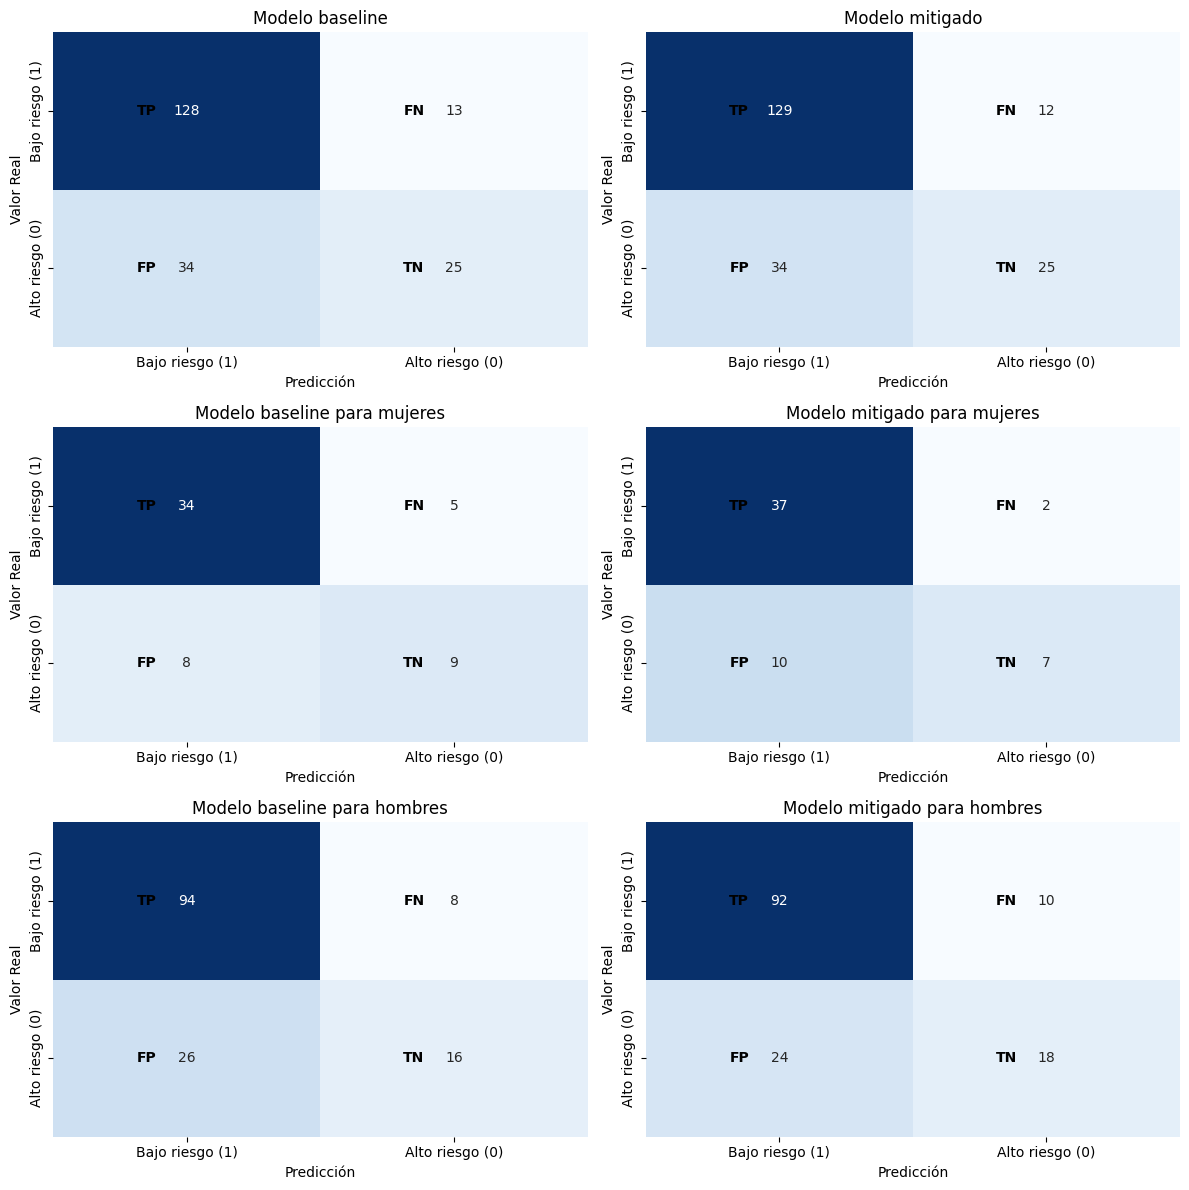

In [7]:
# Visualizamos las matrices de confusión
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
labels = ['Bajo riesgo (1)', 'Alto riesgo (0)']
ax = ax.ravel()

i = 0
for titulo, matriz in matrices.items():
    current_ax = ax[i]

    # Cada uno de los heatmaps
    sns.heatmap(
        matriz,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=current_ax,
        cbar=False,
        xticklabels=labels,
        yticklabels=labels
    )

    # Agrego labels de referencia para mayor claridad
    for (j, k), val in np.ndenumerate(matriz):
        if j == 0 and k == 0:
            label = "TP"
        elif j == 1 and k == 0:
            label = "FP"
        elif j == 0 and k == 1:
            label = "FN"
        else:
            label = "TN"
        current_ax.text(
            k + 0.35, j + 0.5,
            label,
            color="black",
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold"
        )

    #  Configuraciones de labels
    current_ax.set_title(titulo)
    current_ax.set_xlabel("Predicción")
    current_ax.set_ylabel("Valor Real")
    i = i+1

plt.tight_layout()
plt.show()

El modelo entrenado con `PrejudiceRemover` mejoró la _performance_ para el grupo de mujeres, incrementando la cantidad de Positivos Verdaderos (TP, _True Positive_) en 3 casos, además de mejorar en 1 caso los TP del modelo en general. Se pierde un poco la perfomance del grupo privilegiado en el modelo basae, pero se gana en _fairness_, (equidad o igualdad) para los grupos estudiados.

In [8]:
tp_female = [ix for k, ix in enumerate(idx_group_0) if y_test_female[ix] == 1 and y_pred_test_female[k] == 1]
tp_male = [ix for k, ix in enumerate(idx_group_1) if y_test_male[ix] == 1 and y_pred_test_male[k] == 1]
new_tp_female = [ix for k, ix in enumerate(idx_group_0) if y_test_female[ix] == 1 and y_mitigated_pred_test_female[k] == 1 and y_pred_test_female[k] == 0]

df_women_base = german_credit_df.loc[tp_female]
df_men = german_credit_df.loc[tp_male]
df_women_mitigated = german_credit_df.loc[new_tp_female]

In [9]:
# Suponiendo que `df_women` y `df_men` son los DataFrames filtrados
variables_numericas = ['credit_amount', 'duration']
print("Promedios:\n")
print("Mujeres (Baseline):\n", df_women_base[variables_numericas].mean())
print("\nHombres (Baseline):\n", df_men[variables_numericas].mean())
print("\nMujeres (Mitigado):\n", df_women_mitigated[variables_numericas].mean())


Promedios:

Mujeres (Baseline):
 credit_amount    2228.058824
duration           15.941176
dtype: float64

Hombres (Baseline):
 credit_amount    2678.446809
duration           17.000000
dtype: float64

Mujeres (Mitigado):
 credit_amount    3336.0
duration           18.0
dtype: float64


In [10]:
categoricas = ['checking_account_no account', 'credit_history_critical account / other bank', 'housing_own', 'savings_account_unknown / no account', 'property_real estate']
for col in categoricas:
    print(f"\nDistribución de {col}:")
    print("Mujeres (Baseline):\n", df_women_base[col].value_counts(normalize=True).sort_index())
    print("Hombres (Baseline):\n", df_men[col].value_counts(normalize=True).sort_values().sort_index())
    print("Mujeres (Mitigado):\n", df_women_mitigated[col].value_counts(normalize=True).sort_values().sort_index())



Distribución de checking_account_no account:
Mujeres (Baseline):
 checking_account_no account
0    0.323529
1    0.676471
Name: proportion, dtype: float64
Hombres (Baseline):
 checking_account_no account
0    0.521277
1    0.478723
Name: proportion, dtype: float64
Mujeres (Mitigado):
 checking_account_no account
0    1.0
Name: proportion, dtype: float64

Distribución de credit_history_critical account / other bank:
Mujeres (Baseline):
 credit_history_critical account / other bank
0    0.617647
1    0.382353
Name: proportion, dtype: float64
Hombres (Baseline):
 credit_history_critical account / other bank
0    0.638298
1    0.361702
Name: proportion, dtype: float64
Mujeres (Mitigado):
 credit_history_critical account / other bank
0    0.666667
1    0.333333
Name: proportion, dtype: float64

Distribución de housing_own:
Mujeres (Baseline):
 housing_own
0    0.323529
1    0.676471
Name: proportion, dtype: float64
Hombres (Baseline):
 housing_own
0    0.234043
1    0.765957
Name: proporti